In [1]:
# Set directories 
import os
import sys

src_dir = os.path.join(os.getcwd(), '..', 'src')
sys.path.append(src_dir)
data_dir = os.path.join(os.getcwd(), '..', 'data')
output_dir = os.path.join(os.getcwd(), '..', 'output')

# Import Functions
import pandas as pd
import numpy as np
import datetime
from plotnine import ggplot, aes, facet_grid, labs, geom_point,scale_color_gradient, scale_fill_gradient,geom_bar,scale_x_continuous,scale_fill_manual,geom_histogram,theme_bw,geom_boxplot




Questions which are interesting to be adressed:

How do prices change over the year? 
How do the number of available listings change over the year?



The first step is to import the necessary data

In [2]:
calendar = pd.read_csv(data_dir + "/calendar.csv")
listings = pd.read_csv(data_dir + "/listings.csv")
reviews = pd.read_csv(data_dir + "/reviews.csv")

The dataset calenders has the keys listing_id and date. For every row it is indicated whether a specific listing is available on a certain date and if the listing is available what is the price. You can see that that if the listing is available there is always a price given. 

In [3]:
calendar["price_available"] = calendar["price"].isnull()
calendar.groupby(["available","price_available"]).size()

available  price_available
f          True               459028
t          False              934542
dtype: int64

The price is a bit messy and needs to be cleaned up. Also another data.frame is created with only rows which include a price. Then some summary stats for the price are printed out

In [4]:
calendar["price_orig"] = calendar["price"]
calendar["price"] = calendar["price"].replace({'\$': '', ',': ''}, regex=True)
calendar["price"] = pd.to_numeric(calendar['price'])
calendar_wp = calendar.dropna(subset = ["price"]) # calendar with price
calendar_wp = calendar_wp.reset_index(drop=True)
calendar.price.describe()

count    934542.000000
mean        137.944859
std         105.062870
min          10.000000
25%          75.000000
50%         109.000000
75%         160.000000
max        1650.000000
Name: price, dtype: float64

A first look at the data after cleaning the price shows the following. The average price price is 137 euro. The maximum price is 1650 Dollars and the minimum just 10 Dollars. The upper price of 1650 still seems reasonable while a price of 10 Dollars is extremely low. When looking at the other time stamps of the listing_id 4711069 you can see the following (plot). The 10 Dollar listing is an extreme outlier for this listing_id and seems more like a data collection error. 


/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/stats/stat_bin.py:93: PlotnineWarning: 'stat_bin()' using 'bins = 10'. Pick better value with 'binwidth'.


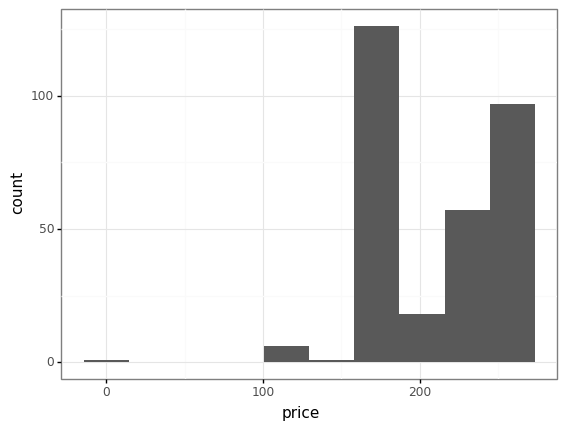

<ggplot: (-9223372036544881790)>

In [5]:
calendar.loc[calendar.price == 10]
(
    ggplot(calendar_wp.loc[calendar_wp.listing_id == 4711069]) +
    aes(x="price") + 
    geom_histogram() +
    theme_bw() 
)

Check the distribution of the price. A few outliers to the top, but these don't seem to be too extreme and could still be explained. 

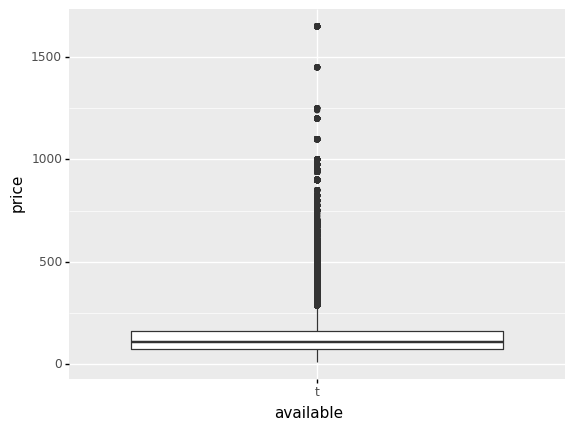

<ggplot: (312733234)>

In [6]:
(
    ggplot(calendar_wp) +
    aes(y="price",x= "available") + 
    geom_boxplot()
)

In [7]:
calendar_wp.loc[:,'date'] = pd.to_datetime(calendar_wp['date'])
calendar_wp['month'] = pd.DatetimeIndex(calendar_wp['date']).month
calendar_wp.loc[:,["month","price"]].groupby("month").describe()

price                                                          
         count        mean         std   min   25%    50%    75%     max
month                                                                   
1      64937.0  122.912176   88.708143  12.0  70.0   99.0  148.0  1000.0
2      73321.0  124.293927   91.550076  20.0  72.0  100.0  149.0  1000.0
3      83938.0  128.644488   94.371410  20.0  75.0  100.0  150.0  1099.0
4      76037.0  135.097005   98.232098  20.0  75.0  110.0  160.0  1099.0
5      79971.0  139.538183  102.863280  20.0  75.0  110.0  169.0  1099.0
6      77244.0  147.473137  112.481803  20.0  76.0  110.0  175.0  1099.0
7      74222.0  152.094150  120.078098  20.0  75.0  115.0  180.0  1240.0
8      76347.0  150.656594  118.754189  20.0  75.0  114.0  179.0  1250.0
9      77246.0  143.255949  108.804290  20.0  75.0  110.0  175.0  1450.0
10     82438.0  137.031939  104.491505  20.0  75.0  109.0  160.0  1650.0
11     81780.0  135.688738  104.264654  10.0  75.0  106.0  155.0  1650.0
12     87061.0  137.251835  105.101659  20.0  75.0  109.0  160.0  1650.0

Plot average price per month with month labels. Clear trend that the prices are higher in summer months

In [8]:
avg_by_month = calendar_wp.groupby("month").agg({"price": ["mean","count"]})
avg_by_month = avg_by_month.droplevel(0, axis=1).reset_index()

In [9]:
months_labels = []
for i in range(1,13):
    months_labels.append(datetime.date(2008, i, 1).strftime('%b'))
break_points = list(range(1,13))
limits = (0,13)

In [10]:
AvgMonthlyPrices = (ggplot(avg_by_month) +
    aes(x= "month",y= "mean") + 
    geom_bar(stat = "identity") +
    theme_bw() +
    labs(x="Month",y = "Average Price",title = "Average Price per Month") +
    scale_x_continuous(breaks = break_points,labels =months_labels,limits=limits)
)

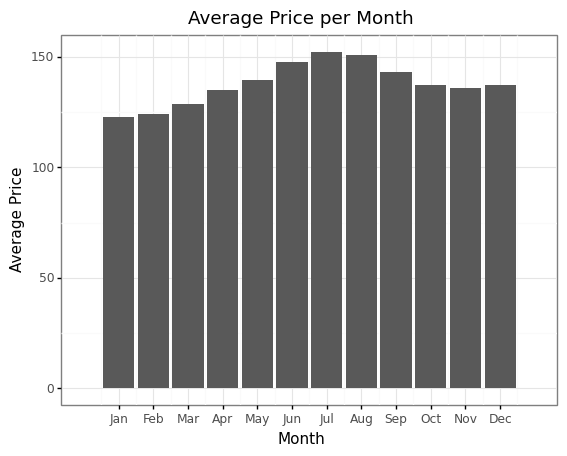

<ggplot: (-9223372036520171120)>

In [11]:
AvgMonthlyPrices 

In [12]:
AvgMonthlyPrices.save(filename = os.path.join(output_dir,"AvgMonthlyPrices.png"))

/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/matthiaslenfers/code/DSBlogPostUdacity/notebooks/../output/AvgMonthlyPrices.png


In [13]:
ListingsPerMonth = (ggplot(avg_by_month) +
    aes(x= "month",y= "count") + 
    geom_bar(stat = "identity") +
    theme_bw() +
    labs(x="Month",y = "Listings",title = "Listings per Month") +
    scale_x_continuous(breaks = break_points,labels =months_labels,limits=limits) #
)

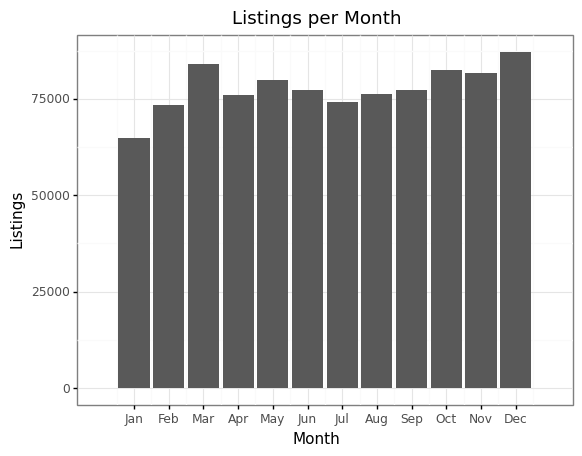

<ggplot: (284411901)>

In [14]:
ListingsPerMonth

In [15]:
ListingsPerMonth.save(filename = os.path.join(output_dir,"ListingsPerMonth.png"))

/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:729: PlotnineWarning: Saving 6.4 x 4.8 in image.
/Users/matthiaslenfers/anaconda3/lib/python3.6/site-packages/plotnine/ggplot.py:730: PlotnineWarning: Filename: /Users/matthiaslenfers/code/DSBlogPostUdacity/notebooks/../output/ListingsPerMonth.png


The next question I wanted to investigate is in how far listings change their price. As the data shows that almost have the users have a difference of no more than 10 Dollars. From here on I did not include the results in the blog post anymore. 

In [17]:
df_price_diff = calendar_wp.groupby(["listing_id"]).agg({"price": ["max","min"]})
df_price_diff = df_price_diff.droplevel(0, axis=1).reset_index()
df_price_diff["diff_max_min"] = df_price_diff["max"] - df_price_diff["min"]

In [18]:
df_price_diff["diff_max_min"].describe()

count    3723.000000
mean       41.663443
std        80.938181
min         0.000000
25%         0.000000
50%        10.000000
75%        45.000000
max      1150.000000
Name: diff_max_min, dtype: float64

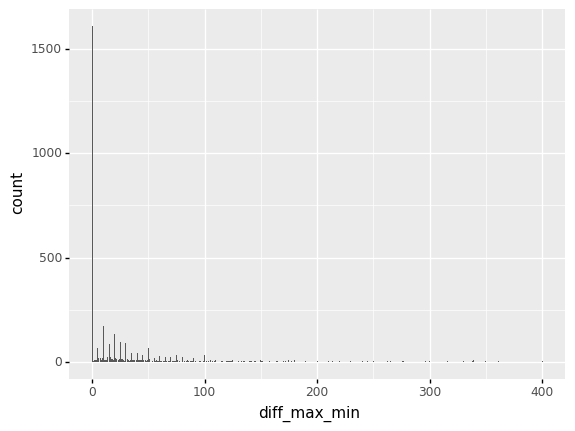

<ggplot: (324158223)>

In [19]:
(
    ggplot(df_price_diff.loc[df_price_diff.diff_max_min <=400]) +
    aes("diff_max_min") + 
    geom_bar()
)

In [20]:
def calc_montly_listings(df_price_diff,calendar_wp,how):
    df = df_price_diff.merge(calendar_wp,how = "left",left_on = ["listing_id",how],right_on = ["listing_id","price"])
    df = df.groupby(["month"]).size().to_frame('listings').reset_index()
    df["Data"] = how 
    return df

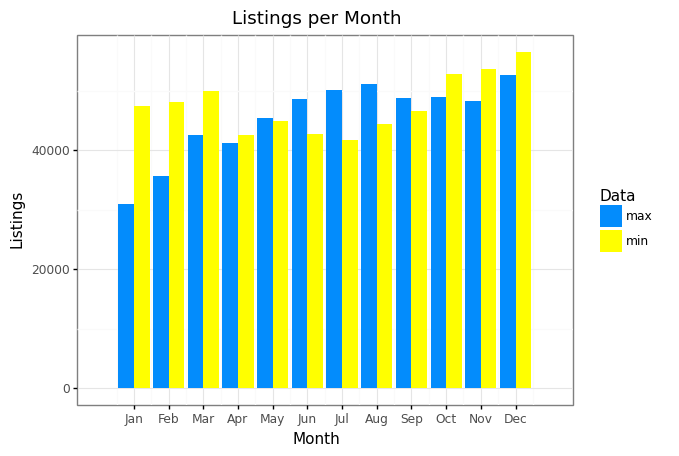

<ggplot: (309874033)>

In [21]:
df = pd.concat([calc_montly_listings(df_price_diff,calendar_wp,"min"),calc_montly_listings(df_price_diff,calendar_wp,"max")])
(
    ggplot(df) +
    aes(x="month",y="listings",fill="Data") + 
    geom_bar(stat = "identity",position = "dodge") + 
    theme_bw() +
    labs(x="Month",y = "Listings",title = "Listings per Month") +
    scale_x_continuous(breaks = break_points,labels =months_labels,limits=limits) +
    scale_fill_manual( values = {"min": "yellow", "max": "#038cfc"})
)

Most people have their highest prices in June, Jul, AUgust and their lowest prices from Oct to March